In [61]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [62]:
IODEPTH_RESULT = './iobandwidth_results.json'
result_jsons = {}
with open(IODEPTH_RESULT, 'r') as f:
    result_jsons = json.load(f)


In [15]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         48 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  16
  On-line CPU(s) list:   0-15
Vendor ID:               AuthenticAMD
  Model name:            AMD Ryzen 9 5900HS with Radeon Graphics
    CPU family:          25
    Model:               80
    Thread(s) per core:  2
    Core(s) per socket:  8
    Socket(s):           1
    Stepping:            0
    Frequency boost:     enabled
    CPU max MHz:         4679.2959
    CPU min MHz:         1200.0000
    BogoMIPS:            6587.68
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall n
                         x mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_go
                         od nopl nonstop_tsc cpuid extd_apicid aperfmperf rapl p
                         ni pclmulqdq monitor

In [16]:
!uname -a

Linux chesetti-rog-g14 6.2.0-36-generic #37~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Oct  9 15:34:04 UTC 2 x86_64 x86_64 x86_64 GNU/Linux


In [17]:
!nproc

16


In [63]:
df = pd.json_normalize(result_jsons)
print(result_jsons[0])
print(df.columns)
io_bandwidth = df[df['experiment_name'] == "CoresVsIOBandwidth"].copy()

{'fio version': 'fio-3.36-17-gafdde5', 'timestamp': 1700101490, 'timestamp_ms': 1700101490191, 'time': 'Wed Nov 15 19:24:50 2023', 'global options': {'ramp_time': '4', 'size': '1G', 'direct': '1', 'runtime': '30', 'lat_percentiles': '1', 'iodepth': '32', 'rw': 'randread'}, 'jobs': [{'jobname': 'CoresVsIOBandwidth_iou', 'groupid': 0, 'job_start': 1700101460175, 'error': 0, 'eta': 0, 'elapsed': 35, 'job options': {'name': 'CoresVsIOBandwidth_iou', 'filename': 'data/input_data', 'numjobs': '1', 'cpus_allowed': '0-0', 'ioengine': 'io_uring'}, 'read': {'io_bytes': 21455310848, 'io_kbytes': 20952452, 'bw_bytes': 715153189, 'bw': 698391, 'iops': 174596.880104, 'runtime': 30001, 'total_ios': 5238081, 'short_ios': 0, 'drop_ios': 0, 'slat_ns': {'min': 2795, 'max': 12115409, 'mean': 5164.336567, 'stddev': 45082.556367, 'N': 5238082}, 'clat_ns': {'min': 39945, 'max': 12351705, 'mean': 177760.332279, 'stddev': 270754.373984, 'N': 5238112, 'percentile': {'1.000000': 103936, '5.000000': 126464, '10.0

In [64]:
def read_iops(jobs):
     return jobs[0]['read']['iops']

def write_iops(jobs):
    # We have group reporting turned on. So read of the first job
     return jobs[0]['write']['iops']

def read_bw(jobs):
    # We have group reporting turned on. So read of the first job
     return jobs[0]['read']['bw']

    
def median_latency(jobs):
    # Some metrics are easier to etract via a json, fow now we'll brute force it
    # jobs_pd = pd.json_normalize(jobs, max_level=0)
    median_lat = jobs[0]['read']['lat_ns']['percentile']['50.000000']
    return median_lat

def num_jobs(jobs):
    return int(jobs[0]['job options']['numjobs'])

def test_transform(x):
    return 10

def summarize_df(df):
    df['readiops'] = df['jobs'].map(read_iops)
    df['writeiops'] = df['jobs'].map(write_iops)
    df['read_bw'] = df['jobs'].map(read_bw)
    df['median_lat'] = df['jobs'].map(median_latency)
    df['numjobs'] = df['jobs'].map(num_jobs)
    df['iodepth'] = df['global options.iodepth'].astype(int)
    df['workload'] = df['global options.rw']

summarize_df(io_bandwidth)
print(io_bandwidth['read_bw'])

0       698391
1       680211
2       675877
3       929295
4       940611
        ...   
283    1112186
284    1084522
285    1097354
286    1109485
287    1091792
Name: read_bw, Length: 288, dtype: int64


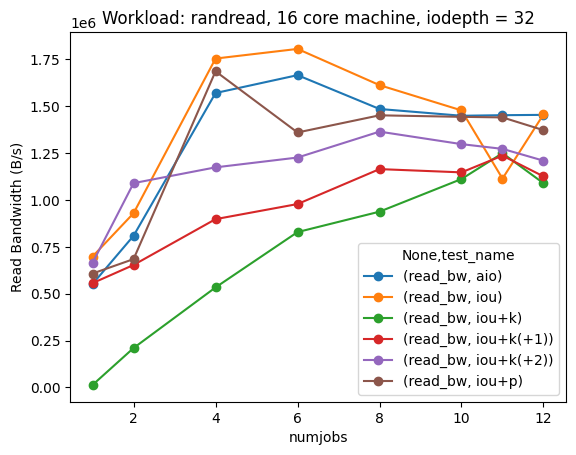

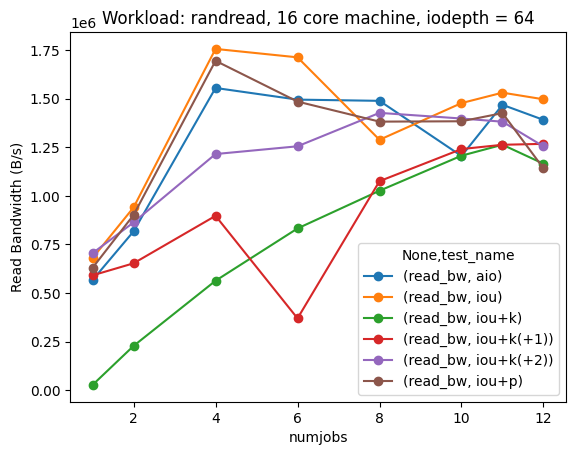

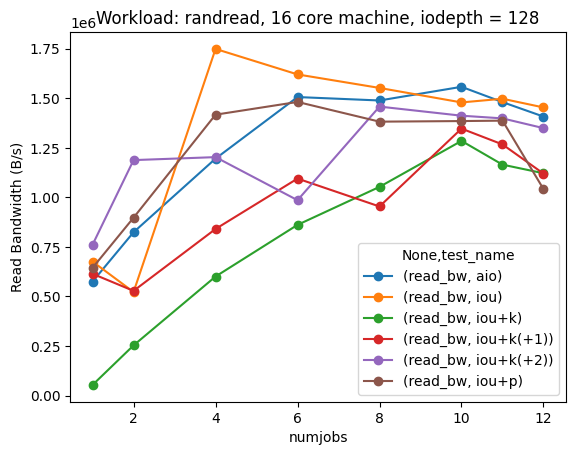

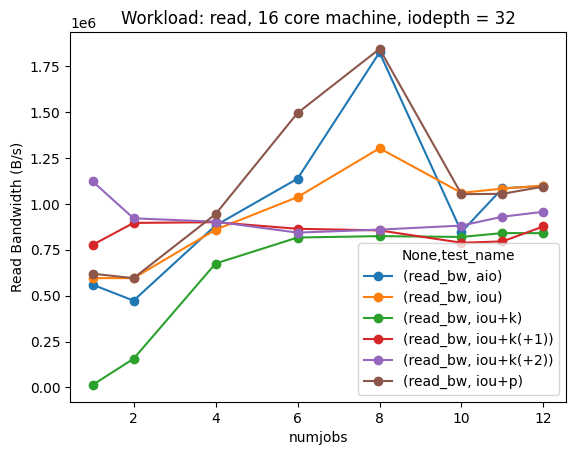

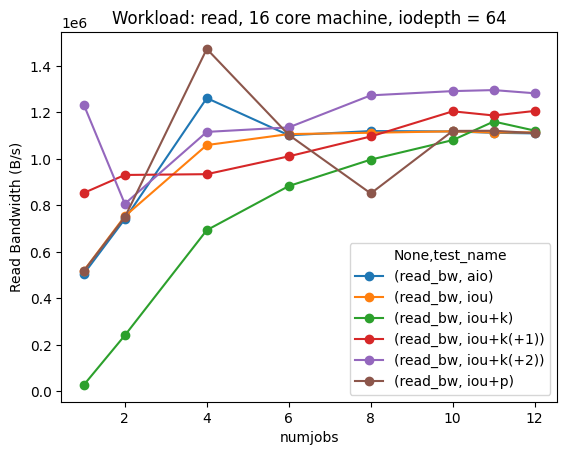

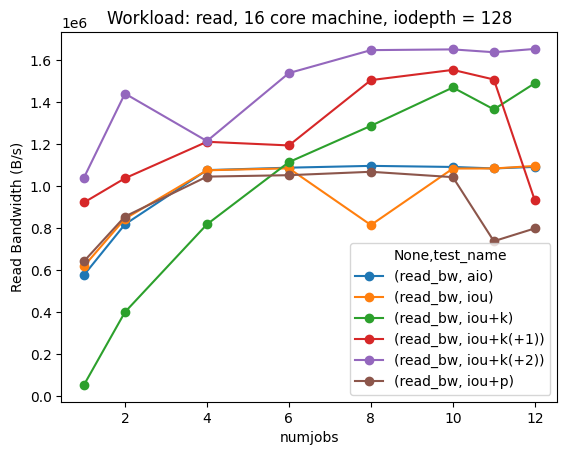

In [85]:
workloads = ["randread", "read"]
io_depths = [32, 64, 128]

for wkl in workloads:
    for iod in io_depths:
        workload = io_bandwidth[io_bandwidth['workload'] == wkl]
        iodepth = workload[workload["iodepth"] == iod]

        plot = iodepth.pivot(index="numjobs", columns=["test_name"], values=["read_bw"]).plot(marker='o')
        plt.ylabel('Read Bandwidth (B/s)')
        plt.title("Workload: {0}, 16 core machine, iodepth = {1}".format(wkl, iod))
        fig = plot.get_figure()
        fig.savefig("{0}_{1}.png".format(wkl, iod))

# io_bandwidth.pivot(index="read_bw", columns=["test_name"], values=["iodepth", "numjobs"])
# io_bandwidth.pivot(index="numjobs", columns=["test_name"], values=["read_bw"]).plot(marker='o')
# plt.ylabel('Read Bandwidth (B/s)')
# plt.title('Workload: RandRead, 16 core machine, IODepth=128')
# io_bandwidth.pivot(index="numjobs", columns=["test_name"], values=["read_bw"])
# io_bandwidth.pivot(index="numjobs", columns=["test_name"], values=["readiops"]).plot()


In [74]:
# io_bandwidth.pivot(index="readiops", columns=["test_name", "numjobs"], values=["iodepth"]).plot(marker='o')

In [73]:
# io_bandwidth_iodepth_4 = io_bandwidth.loc[io_bandwidth['iodepth'] == 4]
# io_bandwidth_iodepth_4.sort_values(by='numjobs')
# io_bandwidth_iodepth_4.pivot(index="numjobs", columns="test_name", values="readiops").plot(marker='o')